# Image segmentation

UNet is a convolutional network that was designed to segment biomedical images. Its success rates are high even with few images in the training set. In this notebook you will learn to implement and use an UNet for image segmentation.

Requirements:
- matplotlib
- torch
- torchvision
- glob

## The problem

Develop a methodology to segment automatically mouse embryos from microscopy images [source](https://bbbc.broadinstitute.org/BBBC003). The dataset contains 15 grayscale images with their corresponding binary masks.

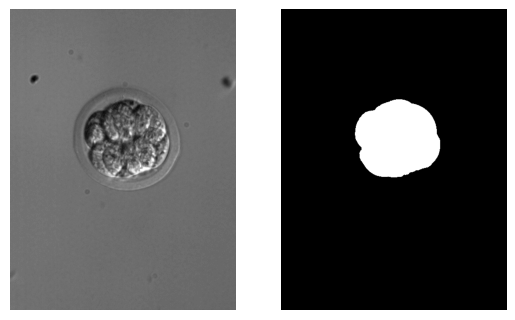

In [1]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.show()
    

im = plt.imread("res/unet/images/7_19_M1E18.tif")
mask = plt.imread("res/unet/masks/7_19_M1E18.tif")
show(im,mask)




## UNet
We are going to segment the images using an UNet. To this end, we are going to follow the next steps:

1. Define the net architecture
2. Generate a training and a validation dataset
3. Train the net
4. Validate the results


First, we set where the code will be run.

In [2]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cpu


### Step 1: Model architecture

You can find online source code for the typical network architectures. In this notebook, we will use [this source code](https://github.com/usuyama/pytorch-unet).

In [3]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Step 2: Load the data

In this step, we are going to load the data by extending the torch class `Dataset`. 

Since the number of examples in our dataset is small, we can apply some transformations (rotations, traslations, blur, ...) to generate artificial samples and, this way, increase the number of samples in our dataset. This is called data augmentation. You can find more information about data augmentation and its implementation in the [pytorch documentation pages](https://pytorch.org/vision/stable/transforms.html).

In [4]:
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random


class EmbryoDataset(Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.tif'))
        self.mask_files = []
        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = plt.imread(img_path)
            mask = plt.imread(mask_path)
            if len(mask.shape) > 2:
                # Some tiff images in this dataset has 4 identical channels :S
                mask = mask[:,:,0]
            
            # Apply the defined transformations to both image and mask
            if self.transform is not None:
                seed = np.random.randint(2147483647) # make a seed with numpy generator 
                random.seed(seed) # apply this seed to image transforms
                torch.manual_seed(seed) 
                image = self.transform(image)
                random.seed(seed) # apply the same seed to mask transforms
                torch.manual_seed(seed) 
                mask = self.transform(mask)
            else:
                t2 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
                image = t2(image)
                mask = t2(mask)
                
                
            return image, mask

    def __len__(self):
        return len(self.img_files)


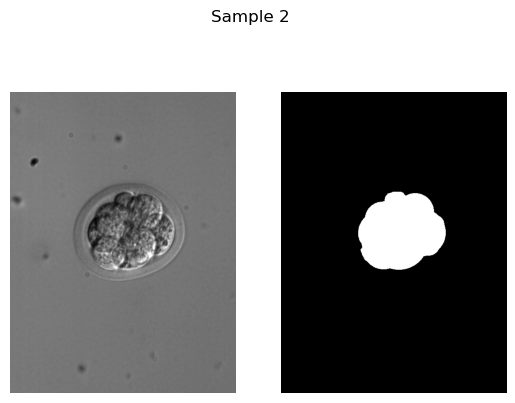

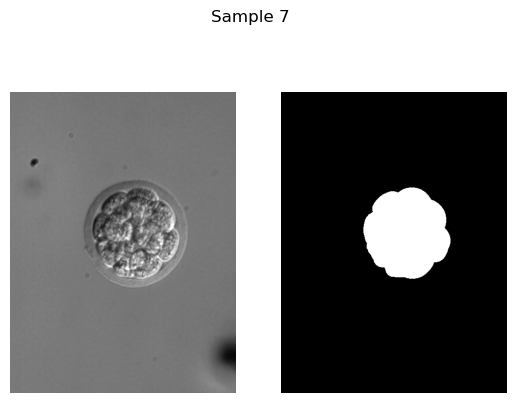

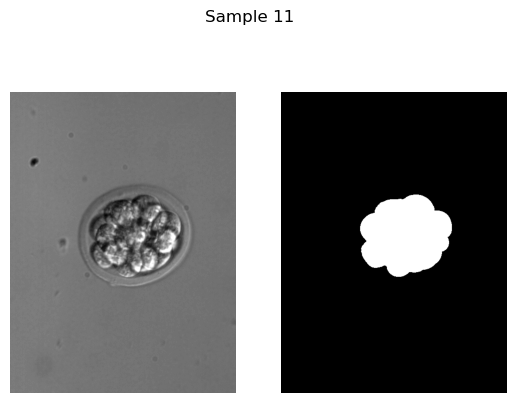

In [5]:
# Load some samples
simple_dataset = EmbryoDataset("res/unet/images", "res/unet/masks")
nsamples = 3
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")
    
# Divide the dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(simple_dataset, [12, 3])

## Step 3: Training

Once the training and validation datasets are created, the next step is training.

In [8]:
# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
#THRESHOLD = 0.2
EPOCHS = 50

# Model
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)


# Loss function
bce_loss = nn.BCEWithLogitsLoss()

# Optimizer
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

#### Exercise
Use the training function that you have implemented in the notebook 1b to train the UNet. Compute the accuracy as the IoU between the segmentation mask and the prediction. 
Feed the net with the original dataset without data augmentation and check the results.

**Hint**: In order to compute the IoU, the function `get_segmentation_masks` can be used to compute a segmentation mask from the outputs of the net. The output of the net is a positive floating point value. The sigmoid function restricts the output domain between 0 and 1. Since the output mask is binary, we use a threshold to set the output mask values to 0 or 1. Note that maybe you should tweak the default threshold.

In [10]:
def get_segmentation_masks(outputs, threshold):
    probs = torch.sigmoid(outputs)
    masks = (probs>threshold)*1.0
    return masks

In [11]:
def compute_iou(outputs, targets, threshold=0.15):
    predicted_masks = get_segmentation_masks(outputs, threshold)
    intersection = torch.logical_and(predicted_masks, targets).sum(dim=(2, 3))
    union = torch.logical_or(predicted_masks, targets).sum(dim=(2, 3))
    iou = (intersection.float() / union.float() + 1e-6).mean()
    return iou.item()

In [93]:
def train_model(model, train_dataset, valid_dataset, device, optimizer, loss, batch_size, num_epochs, output_filename='trained-unet.pt'):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    
    best_loss = 1000000
    iou_evolution = []  # List to store IoU values at each epoch
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss_value = loss(outputs, targets)
            train_loss += loss_value.item()
            
            iou = compute_iou(outputs, targets)
            train_iou += iou
            
            loss_value.backward()
            optimizer.step()
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        
        model.eval()  # Switch to evaluation mode for validation
        valid_loss = 0.0
        valid_iou = 0.0

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)

                loss_value = loss(outputs, targets)
                valid_loss += loss_value.item()

                iou = compute_iou(outputs, targets)
                valid_iou += iou

        valid_loss /= len(valid_loader)
        valid_iou /= len(valid_loader)

        iou_evolution.append(train_iou)  # Add current IoU to the evolution list

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train IoU: {train_iou:.4f} - "
              f"Valid Loss: {valid_loss:.4f} - Valid IoU: {valid_iou:.4f}")
    
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), output_filename)

    print("Training completed.")
    
    return iou_evolution  # Return the IoU evolution list



In [94]:
train_model(unet, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet.pt')

Epoch [1/50] - Train Loss: 0.6548 - Train IoU: 0.0878 - Valid Loss: 0.6487 - Valid IoU: 0.0775
Epoch [2/50] - Train Loss: 0.6436 - Train IoU: 0.0878 - Valid Loss: 0.6246 - Valid IoU: 0.0775
Epoch [3/50] - Train Loss: 0.5461 - Train IoU: 0.0878 - Valid Loss: 0.2978 - Valid IoU: 0.0000
Epoch [4/50] - Train Loss: 0.3509 - Train IoU: 0.0000 - Valid Loss: 0.3066 - Valid IoU: 0.0609
Epoch [5/50] - Train Loss: 0.3398 - Train IoU: 0.0661 - Valid Loss: 0.2837 - Valid IoU: 0.0000
Epoch [6/50] - Train Loss: 0.3181 - Train IoU: 0.0000 - Valid Loss: 0.2820 - Valid IoU: 0.0000
Epoch [7/50] - Train Loss: 0.3109 - Train IoU: 0.0000 - Valid Loss: 0.2815 - Valid IoU: 0.0000
Epoch [8/50] - Train Loss: 0.3067 - Train IoU: 0.0000 - Valid Loss: 0.2793 - Valid IoU: 0.0000
Epoch [9/50] - Train Loss: 0.3035 - Train IoU: 0.0000 - Valid Loss: 0.2777 - Valid IoU: 0.0000
Epoch [10/50] - Train Loss: 0.3015 - Train IoU: 0.0000 - Valid Loss: 0.2743 - Valid IoU: 0.0000
Epoch [11/50] - Train Loss: 0.2985 - Train IoU: 0

[0.08781946574648221,
 0.08781946326295535,
 0.08781946574648221,
 9.999999974752427e-07,
 0.06607796154634116,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 0.06768324714704477,
 0.3400249570828275,
 0.772084653377533,
 0.676835817595323,
 0.5284277610480785,
 0.6804209053516388,
 0.7650975088278452,
 0.7948624640703201,
 0.8154480556646982,
 0.8588976860046387,
 0.8072279890378317,
 0.8689299921194712,
 0.8434831301371256,
 0.8546017706394196,
 0.8789057731628418,
 0.8571675519148508,
 0.8378587861855825,
 0.8620147009690603,
 0.8694490691026052,
 0.9021904667218527,
 0.8943758209546407,
 0.8837293187777201,
 0.8778798679510752,
 0.8729609151681265,
 0.8576278289159139,
 0.8951507608095804,
 0.8744455377260844,
 0.8650645911693573,
 0.8870963553587595,
 0.871439665555954,
 0.852082739273707,
 0.8948113322257996,
 0.

### Step 4: Validate the results

After training we can check the results in the dataset.

In [6]:
def check_segmentation_results(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title="Segmentation masks")

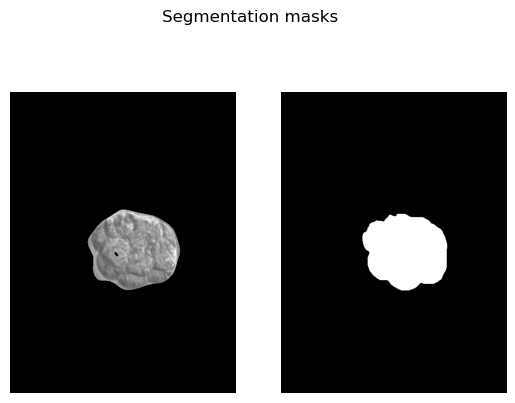

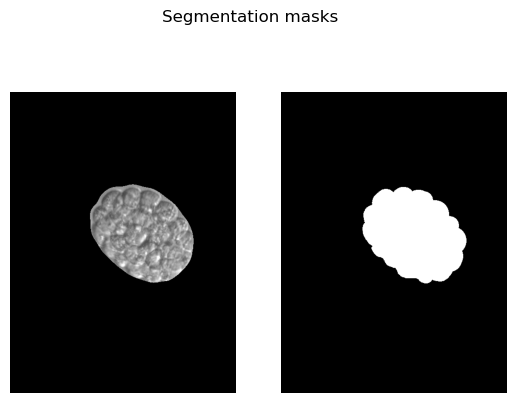

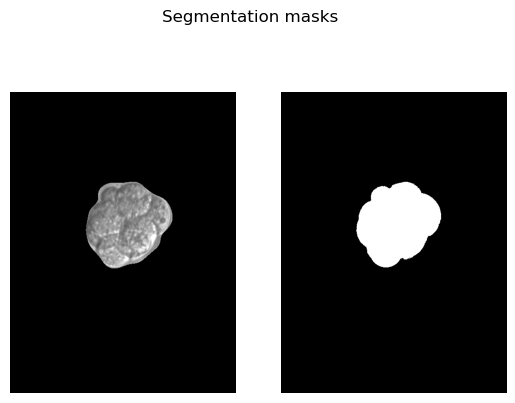

In [12]:
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)
unet.load_state_dict(torch.load('trained-unet.pt'))


check_segmentation_results(unet, valid_dataset, 0.3)

#### Exercise
Modify the function `check_segmentation_results` to include the IoU metric.

In [13]:
def check_segmentation_results_with_acc(model, dataset, threshold=0.5):
    model.eval()
    iou_total = 0
    num_samples = 0
    for image, mask in dataset:
        image = image[None, :, :, :]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)

        # Compute IoU
        intersection = torch.logical_and(predicted_mask, mask).sum()
        union = torch.logical_or(predicted_mask, mask).sum()
        iou = intersection.item() / union.item()

        iou_total += iou
        num_samples += 1

        show(image.cpu().squeeze() * predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title=f"Segmentation mask: IoU {iou:.4f}")

    average_iou = iou_total / num_samples
    print(f"Average IoU: {average_iou:.4f}")

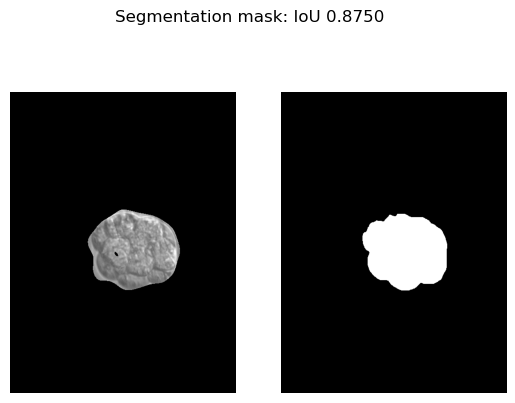

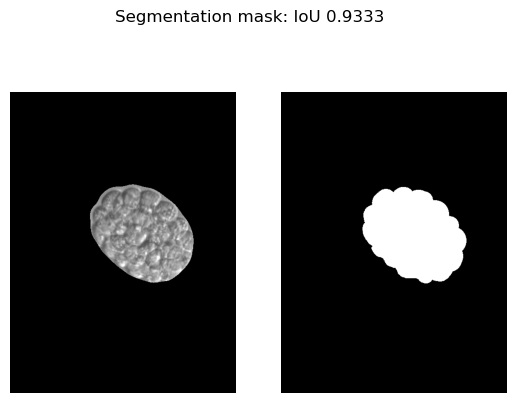

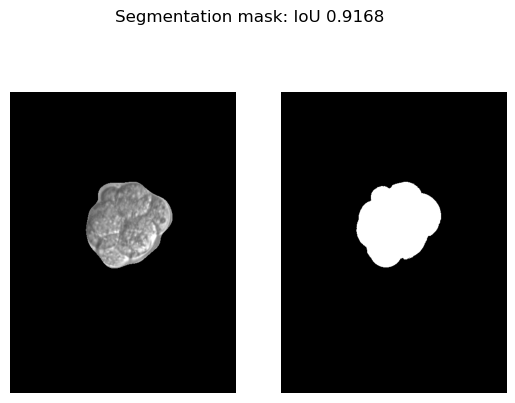

Average IoU: 0.9084


In [14]:
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)
unet.load_state_dict(torch.load('trained-unet.pt'))


check_segmentation_results_with_acc(unet, valid_dataset, 0.3)

### Exercise

Define a set of suitable transforms, train the UNet with data augmentation and check the results.

In [101]:
# Load images with data augmentation
transf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])


augmented_dataset = EmbryoDataset("res/unet/images", "res/unet/masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
#THRESHOLD = 0.5
EPOCHS = 50


# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, 'trained-unet-augmented.pt')



Epoch [1/50] - Train Loss: 0.6703 - Train IoU: 0.0847 - Valid Loss: 0.6614 - Valid IoU: 0.0959
Epoch [2/50] - Train Loss: 0.6415 - Train IoU: 0.0847 - Valid Loss: 0.5772 - Valid IoU: 0.0959
Epoch [3/50] - Train Loss: 0.4364 - Train IoU: 0.0495 - Valid Loss: 0.4248 - Valid IoU: 0.0000
Epoch [4/50] - Train Loss: 0.3277 - Train IoU: 0.0278 - Valid Loss: 0.3600 - Valid IoU: 0.0957
Epoch [5/50] - Train Loss: 0.3175 - Train IoU: 0.0229 - Valid Loss: 0.3452 - Valid IoU: 0.0000
Epoch [6/50] - Train Loss: 0.2988 - Train IoU: 0.0000 - Valid Loss: 0.3148 - Valid IoU: 0.0000
Epoch [7/50] - Train Loss: 0.2850 - Train IoU: 0.0000 - Valid Loss: 0.3023 - Valid IoU: 0.0000
Epoch [8/50] - Train Loss: 0.2805 - Train IoU: 0.0000 - Valid Loss: 0.2959 - Valid IoU: 0.0000
Epoch [9/50] - Train Loss: 0.2756 - Train IoU: 0.0000 - Valid Loss: 0.2924 - Valid IoU: 0.0000
Epoch [10/50] - Train Loss: 0.2717 - Train IoU: 0.0000 - Valid Loss: 0.3037 - Valid IoU: 0.0000
Epoch [11/50] - Train Loss: 0.2657 - Train IoU: 0

[0.08471942196289699,
 0.08471833666165669,
 0.049502321128367534,
 0.027818240065016653,
 0.02294655624890159,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 0.013843250881431382,
 0.026568312307991466,
 0.01849255349317976,
 0.10544883319600255,
 0.32654334507600424,
 0.29228580665464204,
 0.07237407149521384,
 0.20002056654260514,
 0.20042100521453676,
 0.5922596156597137,
 0.13617507616678873,
 0.01786909635940977,
 0.14753217180005626,
 0.07282202329317518,
 0.20203913553984876,
 0.5622868599991003,
 0.5308696966652254,
 0.29419239113728207,
 0.44972345357139903,
 0.3324740305542946,
 0.5660593012968699,
 0.7866823673248291,
 0.7780458927154541,
 0.5398132105668386,
 0.12198663700710692,
 0.12903106460968652,
 0.7569657862186432,
 0.8376842935880026,
 0.6987366179625193,
 0.7635424832503,
 0.7671996653079987,
 0.7663940091927847,
 0.8813

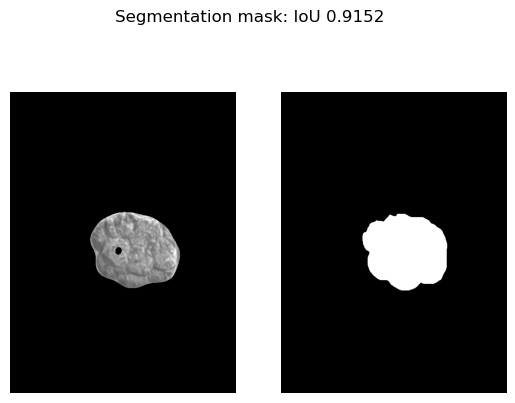

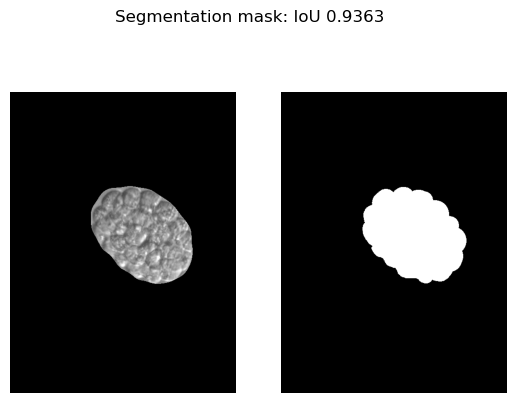

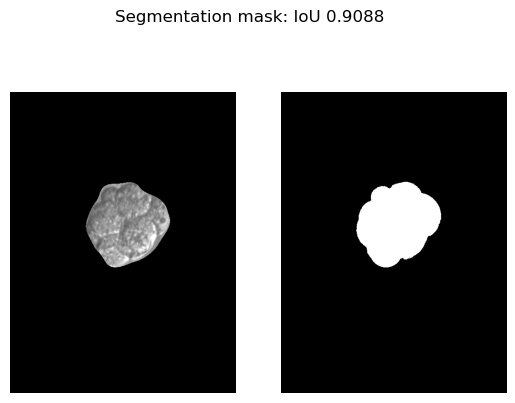

Average IoU: 0.9201


In [17]:
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)
unet_augmented.load_state_dict(torch.load('trained-unet-augmented.pt'))

check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.3)